# Out-of-Distribution Detection

In this tutorial, we are going to train a CNN on the popular MNIST dataset and test it with OOD data. 

In [1]:
import torch 
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Explore MNIST Dataset 
The MNIST dataset contains 60,000 grayscale images of size $28\times28\times1$. 
These images contain number from 0-9, and the task is to predict which number the image shows.  

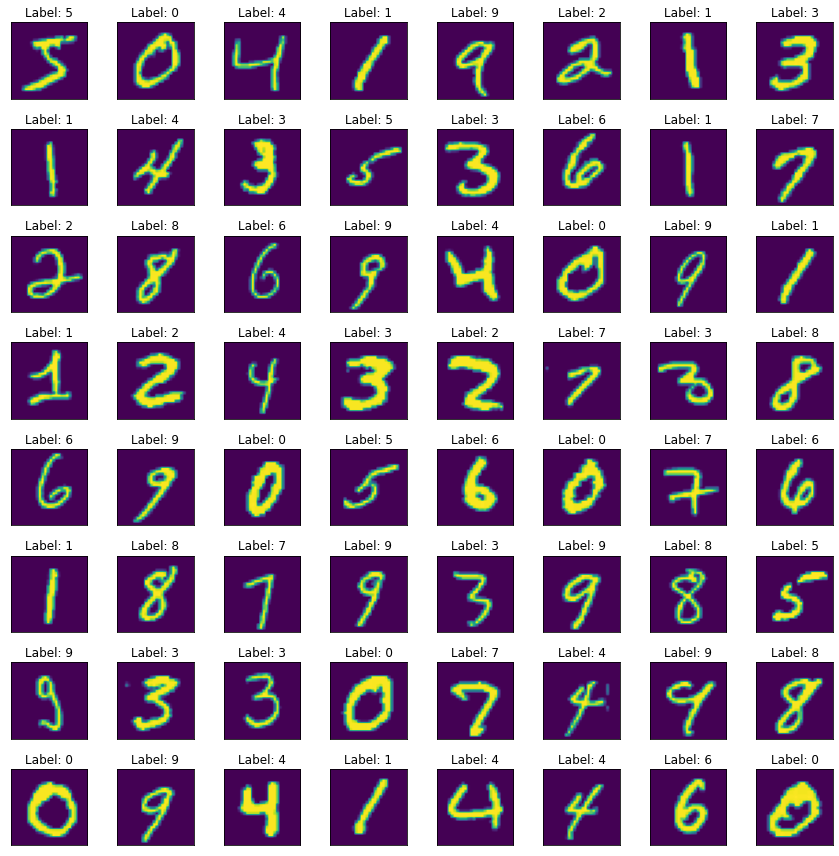

In [2]:
import matplotlib.pyplot as plt 
from torchvision import datasets

train_ds = datasets.MNIST('MNIST', download=True, train=True)

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    x, y = train_ds[i]
    axs[i].imshow(x)
    axs[i].set_title(f"Label: {y}")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)

plt.tight_layout()
plt.show()


## Create a Model 🤖
Now, lets create a CNN to classify the digits

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """Custom module for a simple convnet classifier"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 128, kernel_size=3)
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(128, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # input is bx28x28x1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # bx128x1x1 -> bx128
        x = x.view(-1, 128)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

## Setup dataset and Preprocessing

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(), 
])

train_ds = datasets.MNIST('MNIST', download=True, train=True, transform=transform)
test_ds = datasets.MNIST('MNIST', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

## Train on the MNIST Training-Set

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# create model and optimizer
model = CNN().to(device)
opti = optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train() # set model in training mode (need this because of dropout)
    
    # dataset API gives us pythonic batching 
    for n, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        
        # forward pass, calculate loss and backprop!
        opti.zero_grad()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        opti.step()
        
        if n % 100 == 0:
            print(f"Loss: {loss.item()}")

def test(epoch):
    model.eval() # set model in inference mode (need this because of dropout)
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # we do not require gradients 
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            pred = y_hat.max(dim=1).indices # get the index of the max log-probability
            correct += pred.eq(y).cpu().sum()
            test_loss += loss 
    
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = correct / len(test_ds)
    print(f"Test set: Average loss: {loss:.4f}, Accuracy: {correct}/{len(test_ds)} ({accuracy:.2%})")

for epoch in range(0, 10):
    print(f"Epoch {epoch}")
    train(epoch)
    test(epoch)

Epoch 0
Loss: 2.302344560623169
Loss: 0.9172201156616211
Loss: 0.5476019382476807
Loss: 0.430696576833725
Loss: 0.4131980538368225
Test set: Average loss: 0.0492, Accuracy: 9457/10000 (94.57%)
Epoch 1
Loss: 0.286240816116333
Loss: 0.20260924100875854
Loss: 0.21789228916168213
Loss: 0.2380015254020691
Loss: 0.23757435381412506
Test set: Average loss: 0.0349, Accuracy: 9659/10000 (96.59%)
Epoch 2
Loss: 0.368161678314209
Loss: 0.2987601161003113
Loss: 0.24445047974586487
Loss: 0.2658168077468872
Loss: 0.15455055236816406
Test set: Average loss: 0.0037, Accuracy: 9722/10000 (97.22%)
Epoch 3
Loss: 0.22022847831249237
Loss: 0.10859794914722443
Loss: 0.12744876742362976
Loss: 0.12743180990219116
Loss: 0.1407417356967926
Test set: Average loss: 0.0041, Accuracy: 9770/10000 (97.70%)
Epoch 4
Loss: 0.11410793662071228
Loss: 0.16661062836647034
Loss: 0.14055074751377106
Loss: 0.1167898178100586
Loss: 0.13793529570102692
Test set: Average loss: 0.0017, Accuracy: 9797/10000 (97.97%)
Epoch 5
Loss: 0.

## Test on the MNIST Test-Set 
Our model achieves $\approx 98 \%$ accuracy on the test set. 
Let us inspect some predictions. 

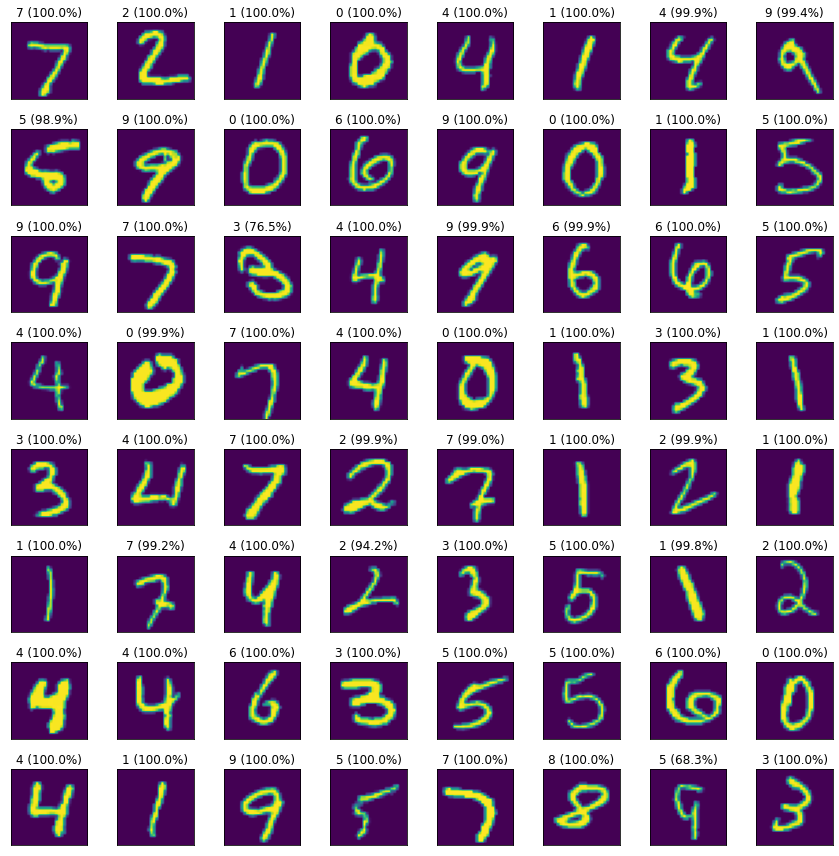

In [6]:
from torchvision.transforms.functional import to_pil_image
model.eval()

for mnist_images, y in test_loader:
    with torch.no_grad():
        y_hat = model(mnist_images.to(device))
        break 

mnist_values, mnist_indices = y_hat.softmax(dim=1).max(dim=1)

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(mnist_images[i]))
    axs[i].set_title(f"{mnist_indices[i]} ({mnist_values[i]:.1%})")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

## Anomalous Data 

Now, what happens if we use the model on images that are not from the MNIST dataset?

In machine learning jargon, the training data is generated by some probability distribution $p_{data}$. 
Different datasets are generated by different probability distributions. 
Thus we call data points from different distributions *out-of-distribution* (OOD) or *anomalies*. 
The goal of anomaly detection is to detect such data points. 

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting OMNIGLOT/omniglot-py/images_background.zip to OMNIGLOT/omniglot-py


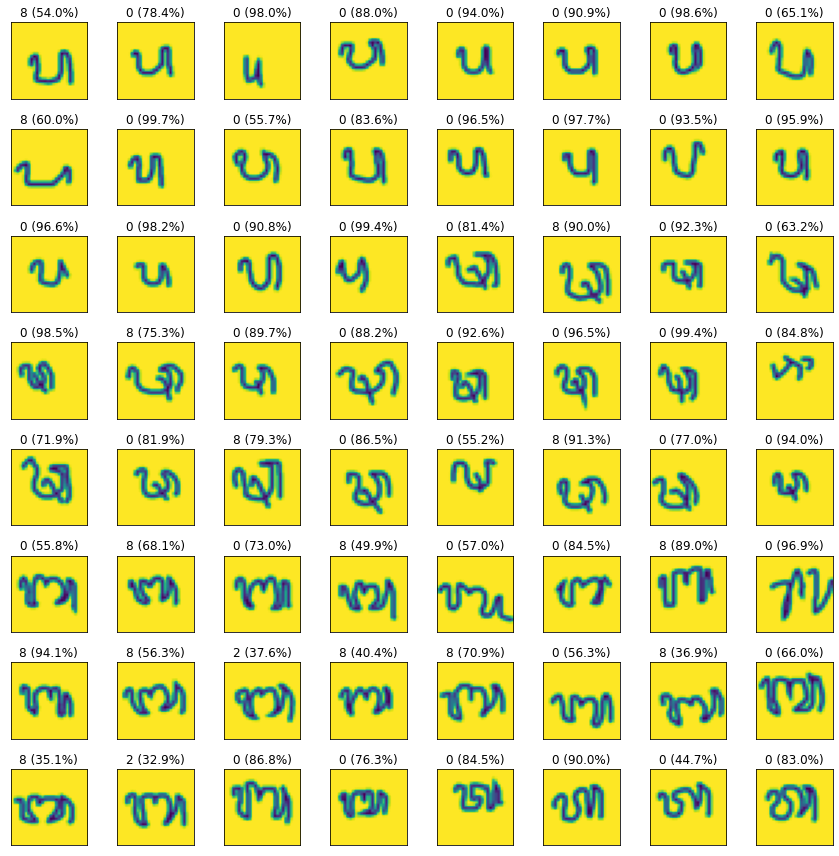

In [7]:
omniglot_ds = datasets.Omniglot('OMNIGLOT', download=True, transform=transform)
omniglot_loader = torch.utils.data.DataLoader(omniglot_ds, batch_size=256, shuffle=False)

for omni_images, y in omniglot_loader:
    with torch.no_grad():
        y_hat = model(omni_images.to(device))
        break 

omni_values, omni_indices = y_hat.softmax(dim=1).max(dim=1)

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(omni_images[i]))
    axs[i].set_title(f"{omni_indices[i]} ({omni_values[i]:.1%})")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)

plt.tight_layout()
plt.savefig("/home/ki/kmnist.png")
plt.show()

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting KMNIST/KMNIST/raw/train-images-idx3-ubyte.gz to KMNIST/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting KMNIST/KMNIST/raw/train-labels-idx1-ubyte.gz to KMNIST/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting KMNIST/KMNIST/raw/t10k-images-idx3-ubyte.gz to KMNIST/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting KMNIST/KMNIST/raw/t10k-labels-idx1-ubyte.gz to KMNIST/KMNIST/raw



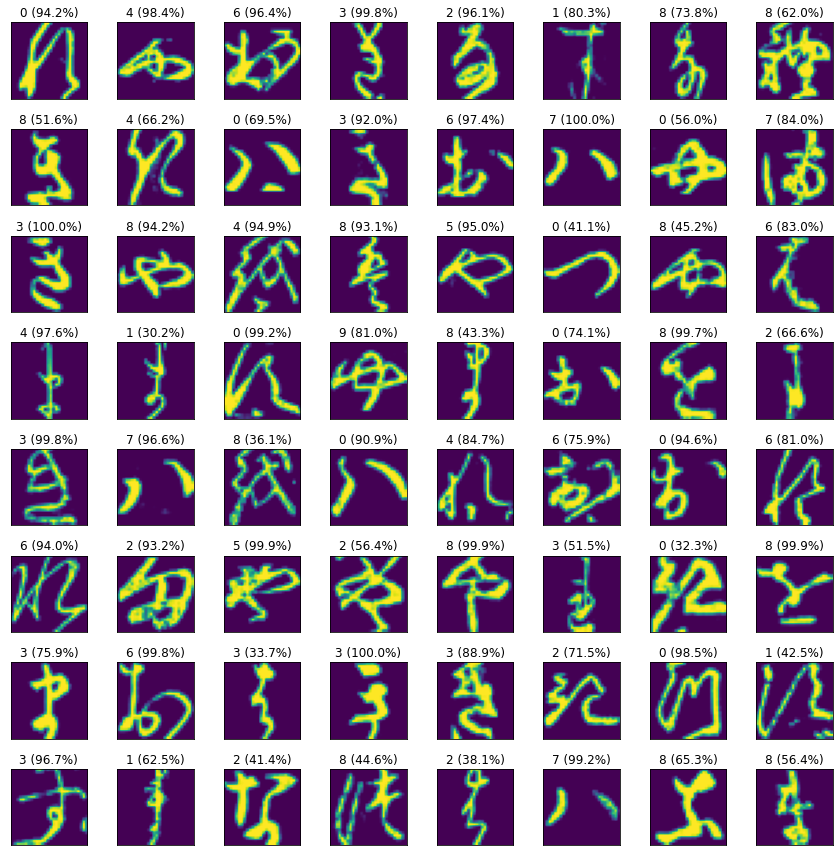

In [8]:
kmnist_ds = datasets.KMNIST('KMNIST', download=True, transform=transform)
kmnist_loader = torch.utils.data.DataLoader(kmnist_ds, batch_size=256, shuffle=False)

for kmnist_images, y in kmnist_loader:
    with torch.no_grad():
        y_hat = model(kmnist_images.to(device))
        break 

kmnist_values, kmnist_indices = y_hat.softmax(dim=1).max(dim=1)

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(kmnist_images[i]))
    axs[i].set_title(f"{kmnist_indices[i]} ({kmnist_values[i]:.1%})")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

## Softmax Thresholding 
As we can see, the model makes predictions which are (or course) incorrect. 
Now, we would like the model to reject such images. 
We notice that the predicted maximum probabilities $\max_y p(y \vert x)$ are generally larger for MNIST images.  
We can inspect the distribution of the maximum softmax values for each dataset by plotting a histogram:

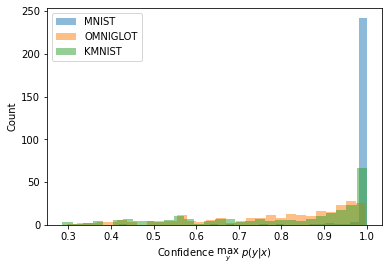

In [19]:
plt.hist(mnist_values.cpu().numpy(), alpha=0.5, label="MNIST", bins=30)
plt.hist(omni_values.cpu().numpy(), alpha=0.5, label="OMNIGLOT", bins=30)
plt.hist(kmnist_values.cpu().numpy(), alpha=0.5, label="KMNIST", bins=30)
plt.legend()
plt.xlabel(f"Confidence $\max_y \ p(y | x)$")
plt.ylabel("Count")
plt.savefig("/home/ki/max-softmax.png", dpi=300)
plt.show()

We see that the anomalies receive lower scores on average. 
With a simple thresholding mechanism, we should be able to reject some of these images. This approach is called **softmax thresholding**. 

**Paper (2017):** https://arxiv.org/abs/1610.02136v2

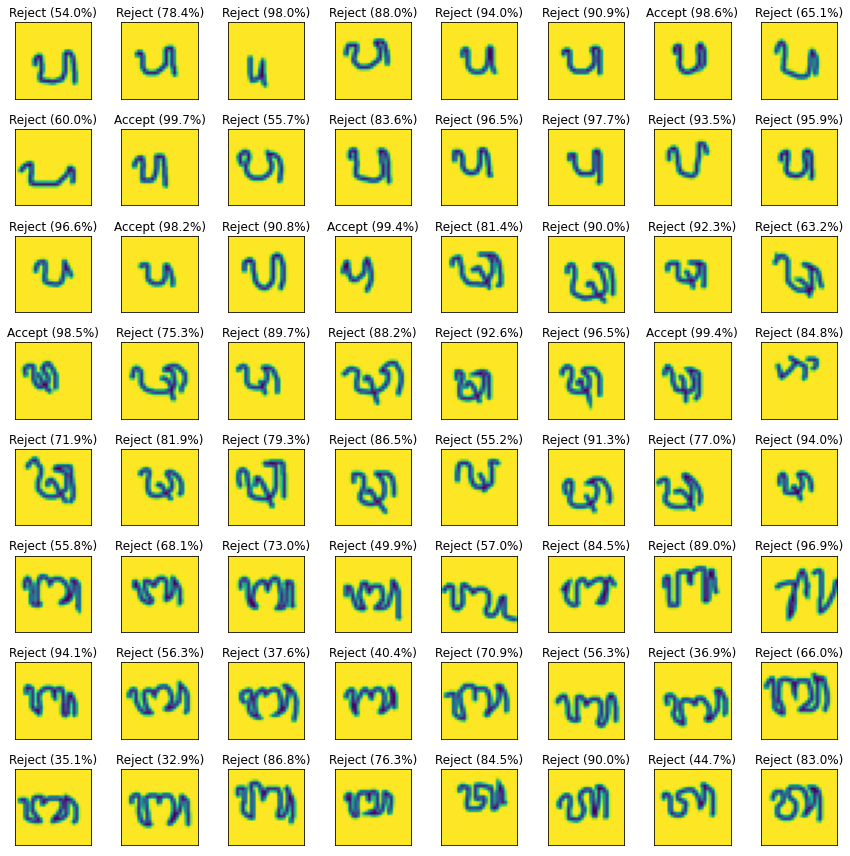

In [10]:
# define a threshold
threshold = 0.98


fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()
new_labels = ["Accept" if c > threshold else "Reject" for c in omni_values]

for i in range(64):
    axs[i].imshow(to_pil_image(omni_images[i]))
    axs[i].set_title(f"{new_labels[i]} ({omni_values[i]:.1%})")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

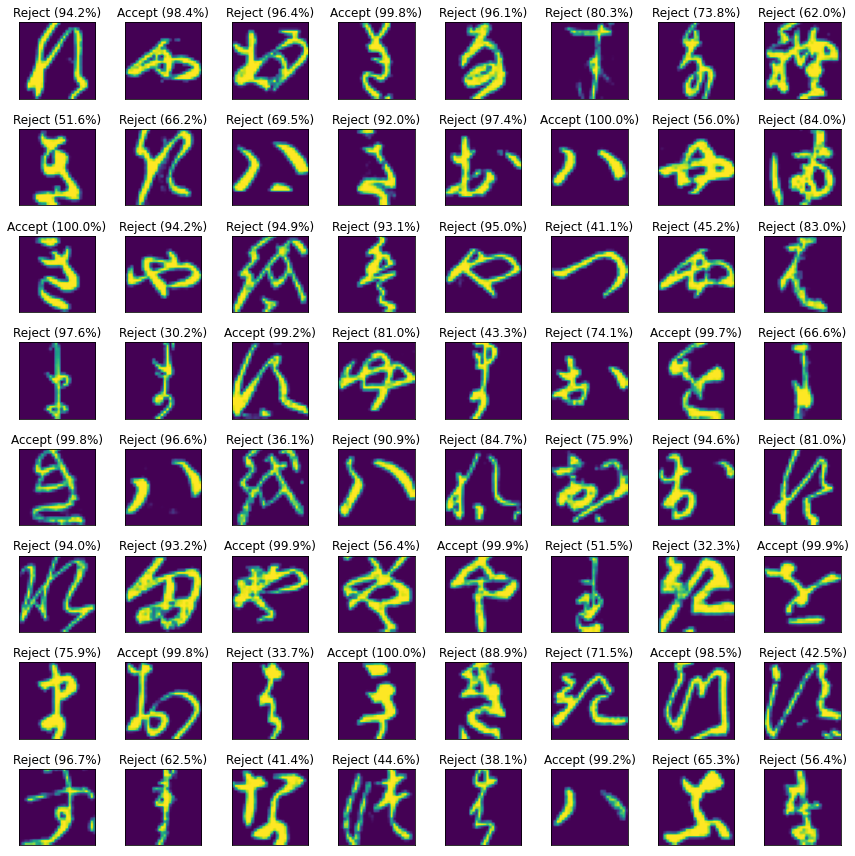

In [11]:
fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()
new_labels = ["Accept" if c > threshold else "Reject" for c in kmnist_values]

for i in range(64):
    axs[i].imshow(to_pil_image(kmnist_images[i]))
    axs[i].set_title(f"{new_labels[i]} ({kmnist_values[i]:.1%})")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

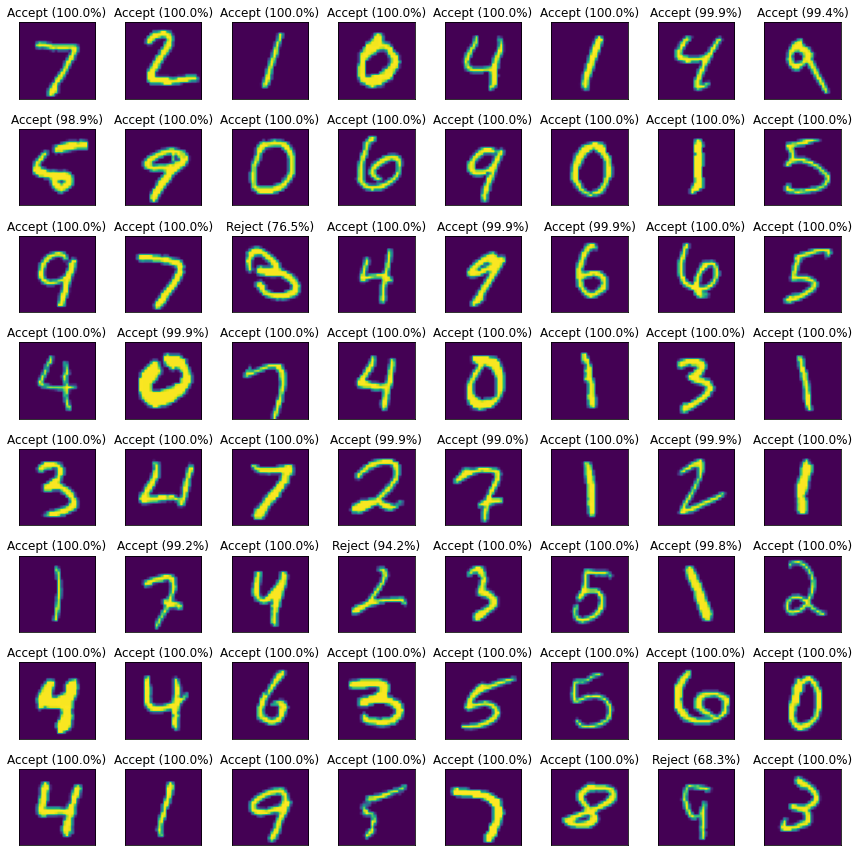

In [12]:
fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()
new_labels = ["Accept" if c > threshold else "Reject" for c in mnist_values]

for i in range(64):
    axs[i].imshow(to_pil_image(mnist_images[i]))
    axs[i].set_title(f"{new_labels[i]} ({mnist_values[i]:.1%})")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

This works, however, there are still some anomalous images that we did not reject (False Negatives). 
Furthermore, there are some MNIST images which we would reject (False Positives).
Apparently, there exists a tradeoff between the False Positive Rate (FPR) and the True Positive Rate (TPR) that depends on the threshold.  

The [Receiver Operating Characetristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) can be used to characterize this tradeoff for all possible thresholds. 

The area under the ROC curve - called AUROC - gives us a scalar metric for the performance of our binary classifier. 

Let us create the ROC for our detector.


In [29]:
from sklearn.metrics import roc_curve, auc
scores = []
labels = []

for x, _ in test_loader:
    with torch.no_grad():
        y_hat = model(x.to(device))
        scores.append(y_hat.softmax(dim=1).max(dim=1).values)
        # set label 1 because Normal
        labels.append(torch.ones(len(x)))

for x, _ in kmnist_loader:
    with torch.no_grad():
        y_hat = model(x.to(device))
        scores.append(y_hat.softmax(dim=1).max(dim=1).values)
        # set label 0 because Anomaly
        labels.append(torch.zeros(len(x)))
        
for x, _ in omniglot_loader:
    with torch.no_grad():
        y_hat = model(x.to(device))
        scores.append(y_hat.softmax(dim=1).max(dim=1).values)
        # set label 0 because Anomaly
        labels.append(torch.zeros(len(x)))

# concatenate batches, move to cpu and convert to numpy 
scores = torch.cat(scores).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

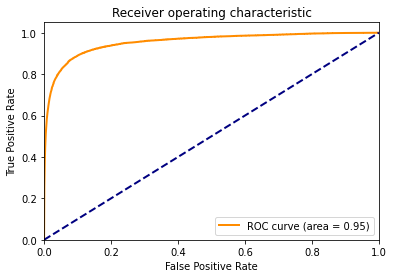

In [38]:
fpr, tpr, _ = roc_curve(labels, scores)
auroc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {auroc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("/home/ki/auroc.png", dpi=300)
plt.show()

# Your Task 
## Energy Based OOD 

Recently, [Energy Based OOD Detection (2020)](https://proceedings.neurips.cc/paper/2020/file/f5496252609c43eb8a3d147ab9b9c006-Paper.pdf) has been proposed. 
The energy-based outlier scores are calculated as
$$ E(z) = - \log(\sum_{i=1}^{n} e^{z_i}) $$ 
where $z \in \mathbb{R}^n$ is the output of the neural network **before** the softmax calculation and $n$ is the number of classes. Your task is to Implement it and compare the results. 

*Hint: torch supports exp(), log(), and sum(), as well as an operation called logsumexp.*

## Outlier Exposure
A very effective method for anomaly detection is to train the model with *outlier exposure*. The idea is to incorporate a number of example anomalies into the training process, such that the outlier scores for these inputs are larger compared to the normal data. 

Can you think of a loss function that would could be used to for our neural network? Discuss different options. 
Now, try to implement one and train a neural network with the KMNIST as outlier data. 
See if it is able to generalize to OMNIGLOT data. 

## Autoencoder 

In [33]:
# Energy-Scores
e_scores = []
e_labels = []

for x, _ in test_loader:
    with torch.no_grad():
        y_hat = model(x.to(device))
        e_scores.append(torch.logsumexp(y_hat, dim=1))
        # set label 1 because Normal
        e_labels.append(torch.ones(len(x)))

for x, _ in kmnist_loader:
    with torch.no_grad():
        y_hat = model(x.to(device))
        e_scores.append(torch.logsumexp(y_hat, dim=1))
        # set label 0 because Anomaly
        e_labels.append(torch.zeros(len(x)))
        
for x, _ in omniglot_loader:
    with torch.no_grad():
        y_hat = model(x.to(device))
        e_scores.append(torch.logsumexp(y_hat, dim=1))
        # set label 0 because Anomaly
        e_labels.append(torch.zeros(len(x)))

# concatenate batches, move to cpu and convert to numpy 
e_scores = torch.cat(e_scores).cpu().numpy()
e_labels = torch.cat(e_labels).cpu().numpy()

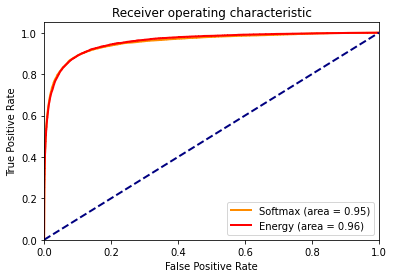

In [37]:
fpr, tpr, _ = roc_curve(labels, scores)
e_fpr, e_tpr, _ = roc_curve(e_labels, e_scores)
e_auroc = auc(e_fpr, e_tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Softmax (area = {auroc:.2f})")
plt.plot(e_fpr, e_tpr, color="red", lw=2, label=f"Energy (area = {e_auroc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("/home/ki/auroc-2.png", dpi=300)
plt.show()